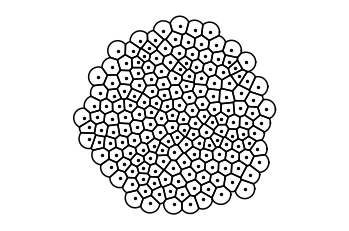

In [6]:
from Organoid import Organoid

org = Organoid()
org.evolution(T=0.0001, file = 'Organoid_mid.csv', ignore=['division', 'displacement'])
org.cellPlot()

(-12.736567661722342,
 11.990159744813853,
 -11.868932033364093,
 12.362272062215066)

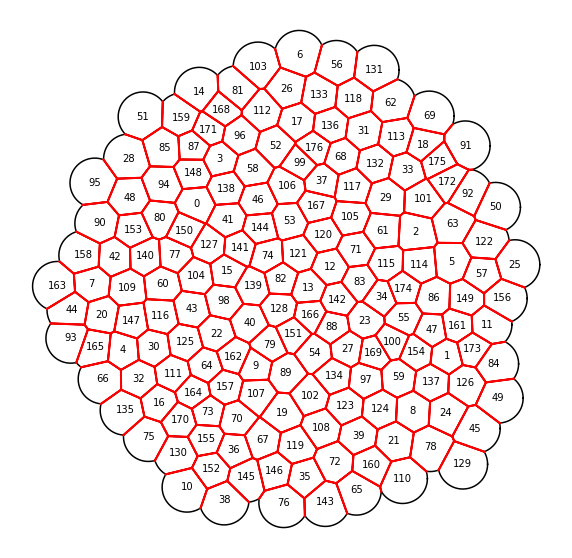

In [7]:
from shapely.geometry import Polygon, Point
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

org.r = np.ones(len(org.pos))*1.1# + np.random.normal(0,0.05,len(org.pos))
r = org.r
polygons = []
cells = [Point(org.pos[i,:]).buffer(r[i]) for i in range(org.nofCells)]
for i in range(org.nofCells):
    indices = np.where((org.dist[i,:] < r[i] + r[:]) & (org.dist[i,:] != 0))
    cell1 = cells[i]

    d = org.dist[i,indices[0]]
    r_neigh = r[indices] 
    a = (r[i]**2 - r_neigh**2 + d**2)/(2*d)
    d12 = org.pos[indices[0],:] - org.pos[i,:]
    d12_orth = np.array([d12[:,1],-d12[:,0]]).T

    rect1 = org.pos[i,:] + d12/d[:,None]*a[:,None] + d12_orth/d[:,None]*r[i]
    rect2 = org.pos[i,:] - d12/d[:,None]*r[i] + d12_orth/d[:,None]*r[i]
    rect3 = org.pos[i,:] - d12/d[:,None]*r[i] - d12_orth/d[:,None]*r[i]
    rect4 = org.pos[i,:] + d12/d[:,None]*a[:,None] - d12_orth/d[:,None]*r[i]

    for j in range(len(indices[0])):

        rectangle = np.array([rect1[j,:],rect2[j,:],rect3[j,:],rect4[j,:]])
        rectangle = Polygon(rectangle)

        cell1 = cell1.intersection(rectangle)

    polygons.append(cell1)


def angle_sorted_neighbors(org):
    neighbors = {}
    tri = Delaunay(org.pos)
    
    for i in range(org.nofCells):
        indices = tri.vertex_neighbor_vertices[1][tri.vertex_neighbor_vertices[0][i]:tri.vertex_neighbor_vertices[0][i+1]]
        
        diff = org.pos[i,:] - org.pos[indices,:]
        distance_indices = indices[norm(diff.T) < org.r[i] + org.r[indices]]
        diff = diff[norm(diff.T) < org.r[i] + org.r[indices]]
        
        angles = np.arctan2(diff[:,1],diff[:,0])
        sorted_indices = [ind for _, ind in sorted(zip(angles, distance_indices))]
        
        neighbors[i] = sorted_indices
        
    return neighbors
    
def circle_intersections(org, neighbors):
    
    intersections = {}
    
    for i in range(org.nofCells):
        for j in neighbors[i]:
            intersect = []
            d = org.dist[i,j]
            a = (org.r[i]**2 - org.r[j]**2 + d**2)/(2*d)
            b = (org.r[i]**2 - a**2)**(1/2)
            d12 = org.pos[j,:] - org.pos[i,:]
            d12_orth = np.array([d12[1],-d12[0]]).T
            xy1 = org.pos[i,:] + a*d12/d + b*d12_orth/d
            xy2 = org.pos[i,:] + a*d12/d - b*d12_orth/d

            intersect.append(xy1)
            intersect.append(xy2)

            intersections[(i,j)] = np.array(intersect)

    return intersections

def line_intersection(xy1, xy2, xy3, xy4):
    x1,y1 = xy1
    x2,y2 = xy2
    x3,y3 = xy3
    x4,y4 = xy4

    beta = ((x3 - x1)*(y2 - y1) - (y3 - y1)*(x2 - x1)) / \
           ((y4 - y3)*(x2 - x1) - (x4 - x3)*(y2 - y1))

    alpha = (x3 - x1)/(x2 - x1) + (x4 - x3)/(x2 - x1)*beta
    
    if alpha >= 0 and alpha <= 1 and beta >= 0 and beta <= 1:
        corner = np.array([x1,y1]) + alpha*np.array([x2-x1,y2-y1])
    else:
        corner = None
    
    return corner
    

def find_edges(intersections, neighbors):
    edges = {}
    for i in range(org.nofCells):
        N = neighbors[i]
        
        if len(N) == 1:
            j = N[0]
            e1 = intersections[(i,j)][0,:]
            e2 = intersections[(i,j)][0,:]
            
            edges[(i,j)] = np.array([e1, e2])
            
        if len(N) == 2:
            j1 = N[0]
            j2 = N[1]
            
            e1 = intersections[(i,j1)][0,:]
            e2 = intersections[(i,j2)][1,:]
            e = line_intersection(intersections[(i,j1)][0,:],
                                  intersections[(i,j1)][1,:],
                                  intersections[(i,j2)][0,:],
                                  intersections[(i,j2)][1,:])
            
            if e is None:
                e12 = intersections[(i,j1)][1,:]
                e21 = intersections[(i,j2)][0,:]
                
                edges[(i,j1)] = np.array([e1, e12])
                edges[(i,j2)] = np.array([e21, e2])  
            else:
                edges[(i,j1)] = np.array([e1, e])
                edges[(i,j2)] = np.array([e, e2])  
            
        else:
        
            for j in range(len(N)):
                j1 = neighbors[i][(j-1) % len(N)]
                j2 = neighbors[i][j]
                j3 = neighbors[i][(j+1) % len(N)]

                if j1 in neighbors[j2]:# and j1 != j3:

                    e1 = line_intersection(intersections[(i,j1)][0,:],
                                           intersections[(i,j1)][1,:],
                                           intersections[(i,j2)][0,:],
                                           intersections[(i,j2)][1,:])

                    if e1 is None:
                        e1 = intersections[(i,j2)][0,:]
                else:
                    e1 = intersections[(i,j2)][0,:]

                if j3 in neighbors[j2]:# and j1 != j3:

                    e2 = line_intersection(intersections[(i,j2)][0,:],
                                           intersections[(i,j2)][1,:],
                                           intersections[(i,j3)][0,:],
                                           intersections[(i,j3)][1,:])

                    if e2 is None:
                        e2 = intersections[(i,j2)][1,:]
                else:
                    e2 = intersections[(i,j2)][1,:]
                
                edges[(i,j2)] = np.array([e1, e2])
            
    return edges
            
            
def norm(x):
    return (x**2).sum(0)**(1/2)

plt.figure(figsize=(10,10))
neighbors = angle_sorted_neighbors(org)
intersections = circle_intersections(org, neighbors)
edges = find_edges(intersections, neighbors)

for i in range(org.nofCells):
    for j in neighbors[i]:
        plt.plot(edges[(i,j)][:,0], edges[(i,j)][:,1], color='r', lw=2, zorder=10)
        
for i in range(org.nofCells):
    plt.text(org.pos[i,0], org.pos[i,1], str(i),horizontalalignment='center',verticalalignment='center')
org.cellPlot(size=0)
plt.axis('equal')
plt.axis('off')

(-12.736567661722342,
 11.990159744813853,
 -11.868932033364093,
 12.362272062215066)

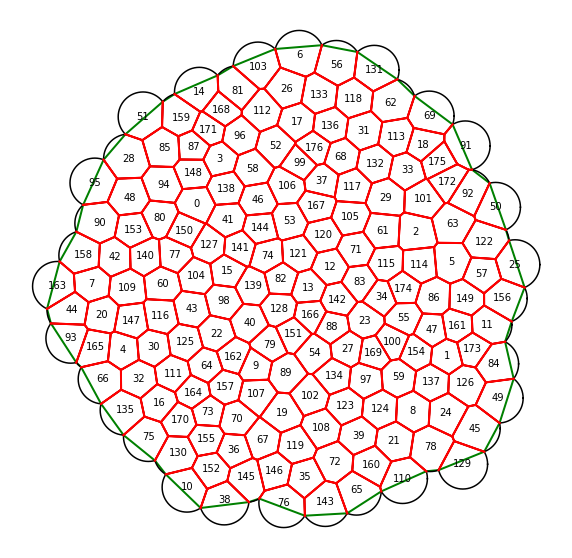

In [8]:
def find_boundary(neighbors, edges):
    boundary = {}
    for i in range(org.nofCells):
        boundaries = []
        for k in range(len(neighbors[i])):
            j1 = neighbors[i][k]
            j2 = neighbors[i][(k + 1) % len(neighbors[i])]

            if (edges[i,j1][1] != edges[i,j2][0]).any():
                boundaries.append(np.array([edges[i,j1][1], edges[i,j2][0]]))
        
        if len(boundaries) > 0:
            boundary[i] = np.array(boundaries)
            
    return boundary

boundary = find_boundary(neighbors, edges)

plt.figure(figsize=(10,10))
neighbors = angle_sorted_neighbors(org)
intersections = circle_intersections(org, neighbors)
edges = find_edges(intersections, neighbors)

for i in range(org.nofCells):
    for j in neighbors[i]:
        plt.plot(edges[(i,j)][:,0], edges[(i,j)][:,1], color='r', lw=2, zorder=10)
        
for i in range(org.nofCells):
    plt.text(org.pos[i,0], org.pos[i,1], str(i),horizontalalignment='center',verticalalignment='center')
    
for i in boundary.keys():
    for j in range(len(boundary[i])):
        plt.plot(boundary[i][j][:,0], boundary[i][j][:,1], lw=2, color='g')
    
org.cellPlot(size=0)
plt.axis('equal')
plt.axis('off')

[5, 2, 115, 174, 86]


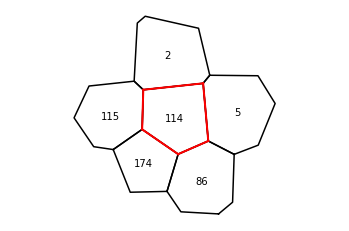

In [9]:
i = 114

x, y = polygons[i].exterior.xy
plt.plot(x,y,'k')

for j in neighbors[i]:
    plt.plot(edges[(i,j)][:,0], edges[(i,j)][:,1], color='r', lw=2, zorder=10)
    x, y = polygons[j].exterior.xy
    plt.plot(x,y,'k')
        
plt.text(org.pos[i,0], org.pos[i,1], str(i),horizontalalignment='center',verticalalignment='center')
for j in neighbors[i]:
    plt.text(org.pos[j,0], org.pos[j,1], str(j),horizontalalignment='center',verticalalignment='center')
#org.cellPlot(size=0)
plt.axis('equal')
plt.axis('off')

print(neighbors[i])

In [10]:
test = line_intersection(intersections[(91,175)][0,:], intersections[(91,175)][1,:],
                         intersections[(91,172)][0,:], intersections[(91,172)][1,:])

In [11]:
j = 1

j1 = neighbors[i][(j-1) % len(neighbors[i])]
j2 = neighbors[i][j]
j3 = neighbors[i][(j+1) % len(neighbors[i])]

x1,y1 = intersections[(i,j1)][0,:]
x2,y2 = intersections[(i,j1)][1,:]
x3,y3 = intersections[(i,j2)][0,:]
x4,y4 = intersections[(i,j2)][1,:]
x5,y5 = intersections[(i,j3)][0,:]
x6,y6 = intersections[(i,j3)][1,:]

print(j1, j2, j3)

5 2 115


In [12]:
V = np.array([polygons[i].area for i in range(org.nofCells)])
E = np.zeros([org.nofCells, org.nofCells])
for i in range(org.nofCells):
    for j in neighbors[i]:
        E[i,j] = norm(edges[(i,j)][0]-edges[(i,j)][1])
        
def dxx():
    D = org.dist.copy()#np.fill_diagonal(org.dist, 1)
    np.fill_diagonal(D, 1)
    offdiag = E/np.reshape(V, [org.nofCells, 1])/D
    diag = np.diag(np.sum(offdiag, axis=1))

    dxx_mat = offdiag - diag

    return dxx_mat

def bc(J):
    bc_vec = np.zeros(org.nofCells)
    for i in boundary.keys():
        val = 0
        for j in range(len(boundary[i])):
            val += norm(boundary[i][j][1] - boundary[i][j][0])*J
            
        bc_vec[i] = val/V[i]
    
    return bc_vec
        
DXX = dxx()
BC = bc(1)

## Diffusion

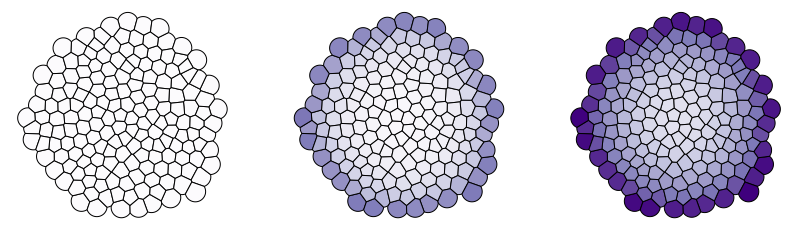

In [13]:
N = 20
T = 1
D = 20
dt = T/N

s = np.zeros([N+1, org.nofCells])
#initials = np.random.choice([i for i in range(org.nofCells)], int(org.nofCells/2), replace=False)
#s[0,initials] = 1
I = np.eye(org.nofCells)
A = (I - dt*D*DXX)

for i in range(N):
    s[i+1,:] = np.linalg.solve(A, s[i,:]) + dt*D*BC

bounds = [np.min(s), np.max(s)]
nofPlots = 3
plt.figure(figsize=(19, 4*(int(nofPlots/4)+1)))
for i in range(nofPlots):
    plt.subplot(int(nofPlots/4)+1,4,i+1)
    j = int(N/(nofPlots-1)*i)
    org.cellPlot(s[j,:], size=0, bounds=bounds, cmap='Purples')

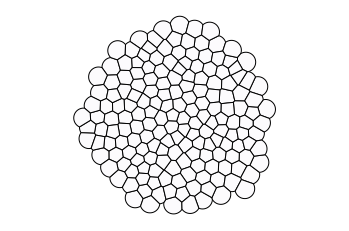

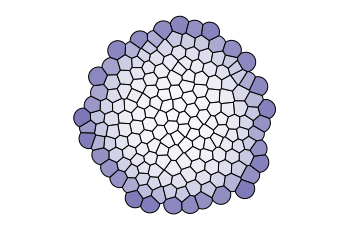

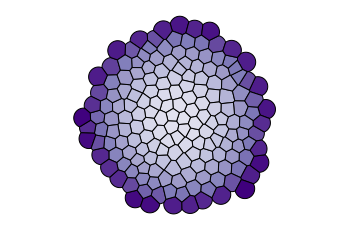

In [14]:
for i in range(nofPlots):
    plt.figure()
    j = int(N/(nofPlots-1)*i)
    org.cellPlot(s[j,:], size=0, bounds=bounds, cmap='Purples')
    plt.savefig('Results/Diffusion/diff_'+str(i)+'.png', transparent=True)

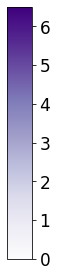

In [126]:
plt.rcParams.update({'font.size': 17})
a = np.array([[np.min(s), np.max(s)]])
plt.figure(figsize=(.7,5))
img = plt.imshow(a, cmap="Purples")
plt.gca().set_visible(False)
cax = plt.axes([0, .3, .5, .7])
plt.colorbar(orientation="vertical", cax=cax)
plt.savefig('Results/Diffusion/diff_cbar.png', transparent=True)

## Diffusion + Decay

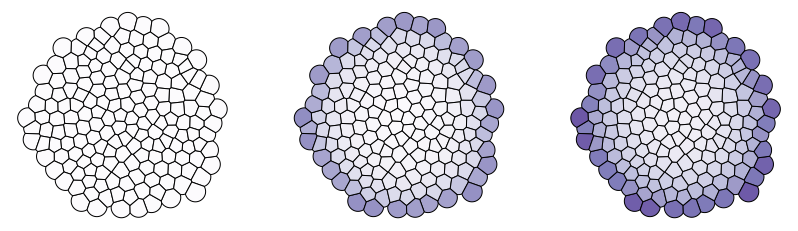

In [127]:
N = 20
T = 1
D = 20
dt = T/N

s = np.zeros([N+1, org.nofCells])
#initials = np.random.choice([i for i in range(org.nofCells)], int(org.nofCells/2), replace=False)
#s[0,initials] = 1
I = np.eye(org.nofCells)
γ = .05
A = (I - dt*D*DXX + γ*I)

for i in range(N):
    s[i+1,:] = np.linalg.solve(A, s[i,:]) + dt*D*BC

#bounds = [np.min(s), np.max(s)]
nofPlots = 3
plt.figure(figsize=(19, 4*(int(nofPlots/4)+1)))
for i in range(nofPlots):
    plt.subplot(int(nofPlots/4)+1,4,i+1)
    j = int(N/(nofPlots-1)*i)
    org.cellPlot(s[j,:], size=0, bounds=bounds, cmap='Purples')

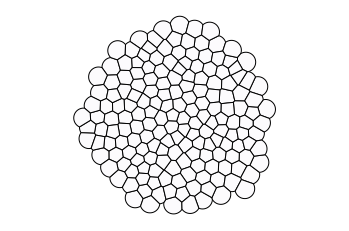

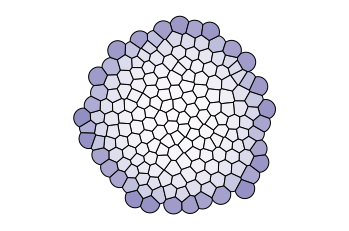

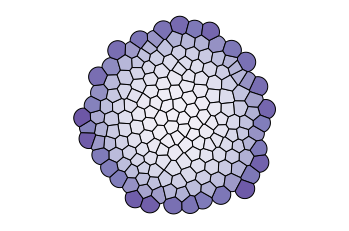

In [128]:
for i in range(nofPlots):
    plt.figure()
    j = int(N/(nofPlots-1)*i)
    org.cellPlot(s[j,:], size=0, bounds=bounds, cmap='Purples')
    plt.savefig('Results/Diffusion/diff+decay_'+str(i)+'.png', transparent=True)

## Diffusion + Decay + Production

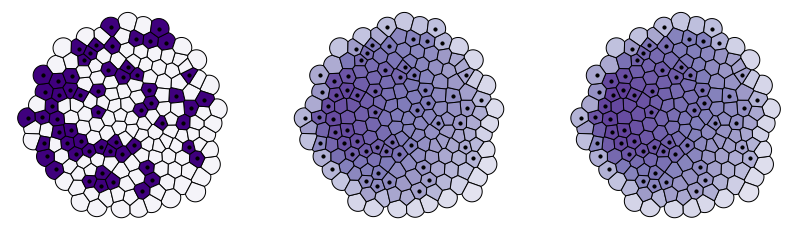

In [18]:
N = 20
T = 1
D = 100
dt = T/N

BC = bc(-1)

s = np.zeros([N+1, org.nofCells])
initials = np.random.choice([i for i in range(org.nofCells)], int(org.nofCells/3), replace=False)
prod = np.zeros(org.nofCells)
prod[initials] = 1
s[0,initials] = 3
I = np.eye(org.nofCells)
γ = 0.1
A = (I - dt*D*DXX + γ*I)

for i in range(N):
    s[i+1,:] = np.linalg.solve(A, s[i,:] + prod) + BC*s[i,:]

bounds = [np.min(s), np.max(s)]
nofPlots = 3
plt.figure(figsize=(19, 4*(int(nofPlots/4)+1)))
for i in range(nofPlots):
    plt.subplot(int(nofPlots/4)+1,4,i+1)
    j = int(N/(nofPlots-1)*i)
    org.cellPlot(s[j,:], size=0, bounds=bounds, cmap='Purples')
    plt.scatter(org.pos[initials,0], org.pos[initials,1], color='k', s = 10, zorder=10)

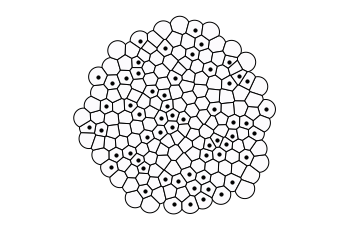

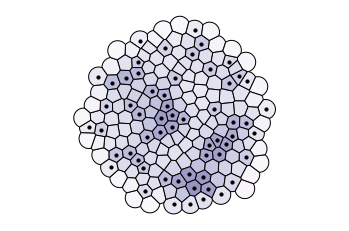

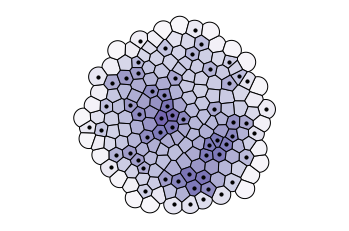

In [186]:
for i in range(nofPlots):
    plt.figure()
    j = int(N/(nofPlots-1)*i)
    org.cellPlot(s[j,:], size=0, bounds=bounds, cmap='Purples')
    plt.scatter(org.xy[initials,0], org.xy[initials,1], color='k', s = 10, zorder=10)
    plt.savefig('Results/Diffusion/diff+prod+decay_'+str(i)+'.png', transparent=True)

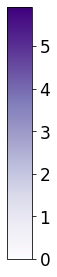

In [189]:
plt.rcParams.update({'font.size': 17})
a = np.array([[np.min(s), np.max(s)]])
plt.figure(figsize=(.7,5))
img = plt.imshow(a, cmap="Purples")
plt.gca().set_visible(False)
cax = plt.axes([0, .3, .5, .7])
plt.colorbar(orientation="vertical", cax=cax)
plt.savefig('Results/Diffusion/prod_cbar.png', transparent=True)

In [134]:
print(s[0,:])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Diffusion + Decay + Production + Uptake

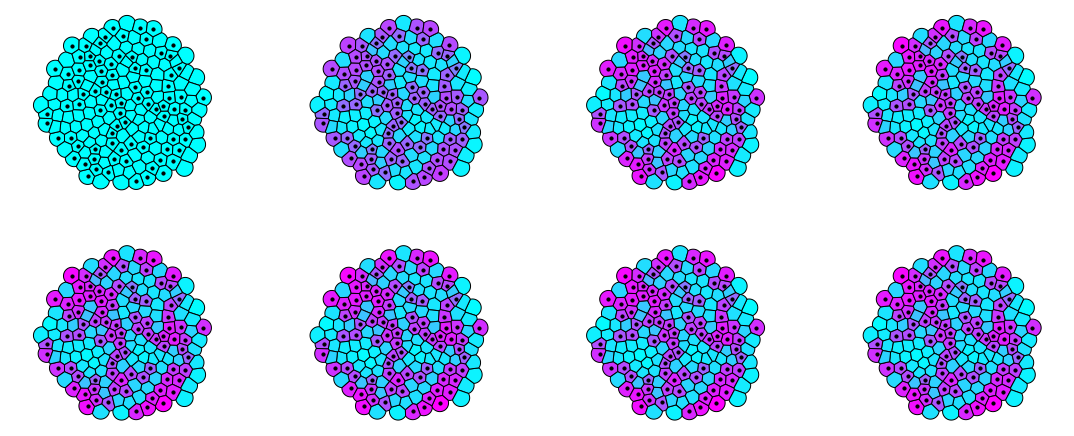

In [26]:
N = 20
T = 1
D = 10
dt = T/N

s = np.zeros([N+1, org.nofCells])
initials = np.random.choice([i for i in range(org.nofCells)], int(org.nofCells/2), replace=False)
prod = np.zeros(org.nofCells)
prod[initials] = 10
uptake = 1*np.ones(org.nofCells)
uptake[initials] = 0
I = np.eye(org.nofCells)
γ = 1
A = (I - dt*D*DXX + γ*I)

for i in range(N):
    s[i+1,:] = np.linalg.solve(A, s[i,:] + prod - uptake*s[i,:])

bounds = [np.min(s), np.max(s)]
nofPlots = 8
plt.figure(figsize=(19, 4*(int(nofPlots/4)+1)))
for i in range(nofPlots):
    plt.subplot(int(nofPlots/4)+1,4,i+1)
    j = int(N/(nofPlots-1)*i)
    org.cellPlot(s[j,:], size=0, bounds=bounds)
    plt.scatter(org.xy[initials,0], org.xy[initials,1], color='k', s = 10, zorder=10)

0.8747767912468626 0.023616721757424772 0.6676143747897432 0.059377782907743135
max uptake: 0.058401356056885186    max production: 1.0
min uptake: 0.0015766862930666466    min production: 0.11875556581548627
0.004277198680535888 0.0678314411455125 0
0.000407381146596216 0.019209377531513777 7
0.000420022599157122 0.0015331856472406873 14
0.0004073811466345582 0.0005186037276925985 21
0.000420022599157122 0.0015331856472406873 28
0.0004073811466345582 0.0005186037276925985 35
0.000420022599157122 0.0015331856472406873 42
0.000420022599157122 0.0015331856472406873 50
0.17189696069966875 0.0025594705943281565


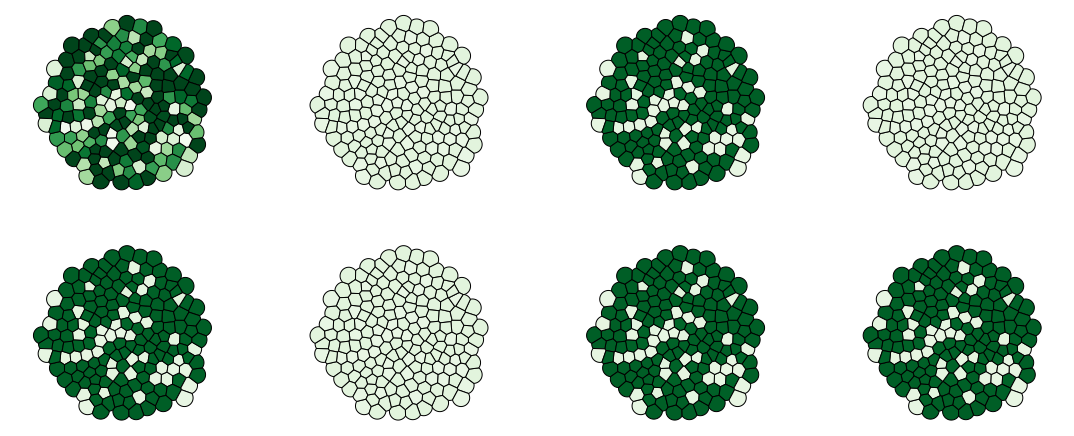

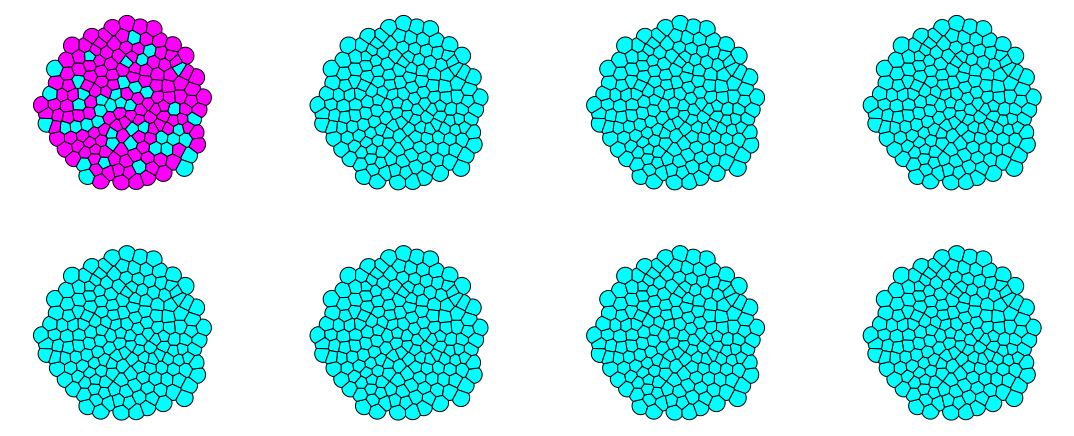

In [33]:
x = np.exp(-1)

η_x = np.exp(1)
η_u = np.exp(6)
η_v = np.exp(5)
η_s = np.exp(3)
η_vx = np.exp(2)

r_w = 1
r_s = 2
γ_w = 10
γ_s = 10

p = lambda f: η_x*x/(f + η_x*x)
p_s = lambda s: η_s*s/(1 + η_s*s)
f_w = lambda u, v: (1 + η_u*u)*(1 + η_v*v)/(1 + η_v*η_vx*v)
f_p = lambda v: 1 + η_v*v

print(p(f_w(0,0.1)), p(f_w(0.1,0)), p_s(0.1), p(f_p(0.1)))
print('max uptake:', r_w/γ_w*p(f_w(0,0.1))*p_s(0.1), '   max production:', r_s*p(f_p(0.)))
print('min uptake:', r_w/γ_w*p(f_w(0.1,0))*p_s(0.1), '   min production:', r_s*p(f_p(0.1)))

s_crit = 0.04

N = 50
T = 1
D = 10
dt = T/N

s = np.zeros([N+1, org.nofCells])
s_received = np.random.uniform(0, 2*s_crit, org.nofCells)
u = np.zeros(org.nofCells)
v = np.zeros(org.nofCells)
s[0,:] = s_received/(1 - s_received)/p(f_w(u,v))
uptake = r_w/γ_w*p(f_w(u,v))*p_s(s[0,:])
u[uptake > s_crit] = 0.1
v[uptake <= s_crit] = 0.1

I = np.eye(org.nofCells)
A = (I - dt*D*DXX + γ_s*I)

for i in range(N):
    prod = r_s*p(f_p(v))
    uptake = r_w/γ_w*p(f_w(u,v))*p_s(s[i,:])
    
    u = np.zeros(org.nofCells)
    v = np.zeros(org.nofCells)
    u[uptake > s_crit] = 0.1
    v[uptake <= s_crit] = 0.1
    
    s[i+1,:] = np.linalg.solve(A, s[i,:] + prod - uptake)

bounds = [0,0.1]#[np.min(s), np.max(s)]
nofPlots = 8
plt.figure(figsize=(19, 4*(int(nofPlots/4)+1)))
for i in range(nofPlots):
    plt.subplot(int(nofPlots/4)+1,4,i+1)
    j = int(N/(nofPlots-1)*i)
    org.cellPlot(s[j,:], size=0, bounds=bounds, cmap='Greens')
    
plt.figure(figsize=(19, 4*(int(nofPlots/4)+1)))
for i in range(nofPlots):
    plt.subplot(int(nofPlots/4)+1,4,i+1)
    j = int(N/(nofPlots-1)*i)
    
    uptake = r_w/γ_w*p(f_w(u,v))*p_s(s[j,:])
    print(min(uptake), max(uptake),j)
    u = np.zeros(org.nofCells)
    v = np.zeros(org.nofCells)
    u[uptake < s_crit] = 0.1
    v[uptake >= s_crit] = 0.1

    org.cellPlot(v, size=0, bounds=[0,0.1])
    
print(np.max(s), np.min(s))

0.0015957339545585537 0.0979767725607422
0.001497264383884302 0.09170720745123044
0.07309601198522625 0.09491339928035565
0.09122754787079146 0.09670686176759859
0.09590892489132131 0.0973016219800979
0.09712904865137935 0.0974935444617771
0.09745807361348378 0.0975541544279987
0.09755333472040144 0.09757425928977799


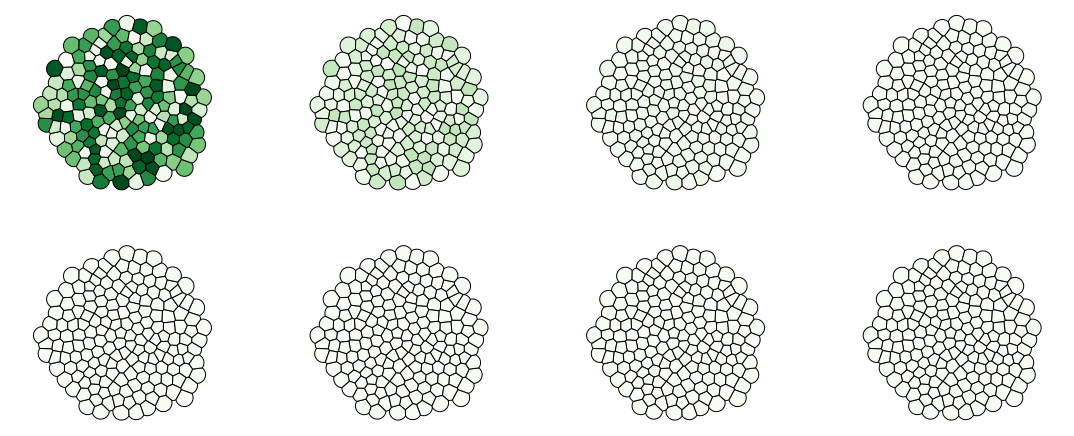

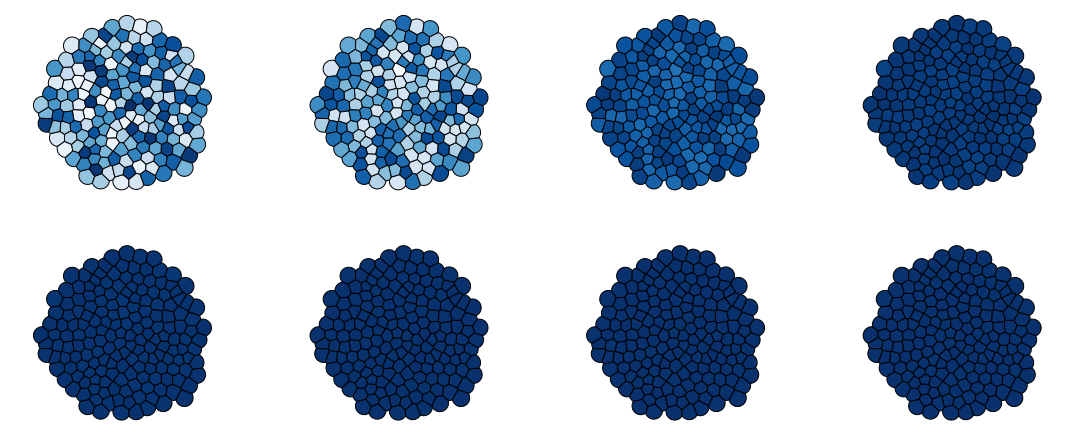

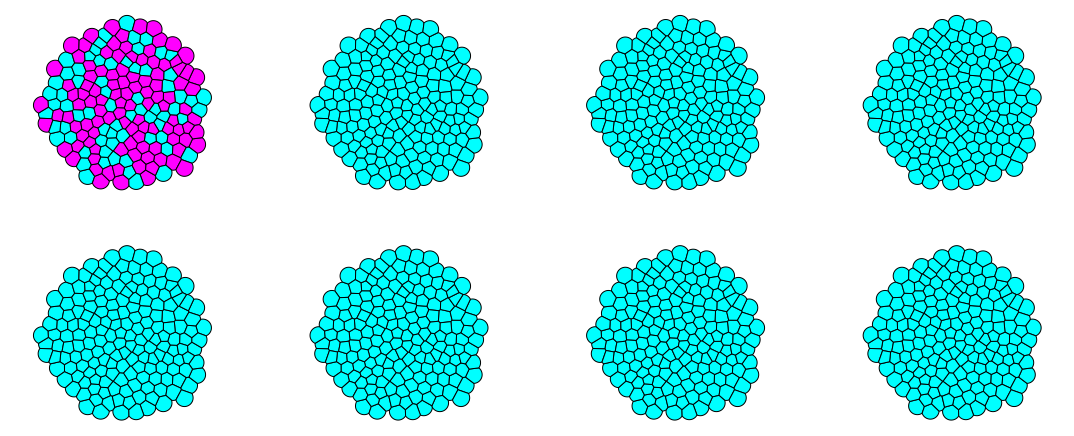

In [125]:
η_u = np.exp(7)
η_v = np.exp(6)
η_s = np.exp(3)
η_vx = np.exp(2)

r_u = 1
r_v = 1
r_s_int = 1
r_s_ext = 1
γ_u = 10
γ_v = 10
γ_s_int = 10
γ_s_ext = 10

p_u = lambda u, v: η_u*u/(1 + η_u*u + η_v*v)
p_v = lambda u, v: η_v*v/(1 + η_u*u + η_v*v)

s_crit = 0.04

N = 50
T = 1
Diff = 1
dt = T/N

s_full = np.zeros([N+1, org.nofCells*2])
s_full[0,:] = np.random.uniform(0,0.1,org.nofCells*2)
s_int = s_full[0,:org.nofCells]

u = np.zeros(org.nofCells)
v = np.zeros(org.nofCells)

u[s_int < s_crit] = 0.1
v[s_int >= s_crit] = 0.1

I = np.eye(org.nofCells)
A = (1 + dt*γ_s_int)*I
B = dt*r_s_int*p_v(u,v)*I
C = np.zeros([org.nofCells, org.nofCells])
D = ((1 + dt*γ_s_ext)*I - dt*Diff*DXX)

M = np.block([[A, B],
              [C, D]])

for i in range(N):
    
    B = dt*r_s_int*p_v(u,v)*I
    D = ((1 + dt*γ_s_ext + r_s_ext*p_v(u,v))*I - dt*Diff*DXX)
    M = np.block([[A, C],
                  [C, D]])
    
    rhs = np.block([s_full[i,:org.nofCells],
                    s_full[i,org.nofCells:] + dt*r_s_ext*p_u(u,v)])
    
    u = np.zeros(org.nofCells)
    v = np.zeros(org.nofCells)
    u[s_full[i,:org.nofCells] < s_crit] = 0.1
    v[s_full[i,:org.nofCells] >= s_crit] = 0.1
    
    s_full[i+1,:] = np.linalg.solve(M, rhs)

bounds = [np.min(s_full[:,:org.nofCells]), np.max(s_full[:,:org.nofCells])]
nofPlots = 8
plt.figure(figsize=(19, 4*(int(nofPlots/4)+1)))
for i in range(nofPlots):
    plt.subplot(int(nofPlots/4)+1,4,i+1)
    j = int(N/(nofPlots-1)*i)
    org.cellPlot(s_full[j,:org.nofCells], size=0, bounds=bounds, cmap='Greens')
    #print(min(s_full[j,:org.nofCells]), max(s_full[j,:org.nofCells]))
    
bounds = [np.min(s_full[:,org.nofCells:]), np.max(s_full[:,org.nofCells:])]
nofPlots = 8
plt.figure(figsize=(19, 4*(int(nofPlots/4)+1)))
for i in range(nofPlots):
    plt.subplot(int(nofPlots/4)+1,4,i+1)
    j = int(N/(nofPlots-1)*i)
    org.cellPlot(s_full[j,org.nofCells:], size=0, bounds=bounds, cmap='Blues')
    print(min(s_full[j,org.nofCells:]), max(s_full[j,org.nofCells:]))
    
plt.figure(figsize=(19, 4*(int(nofPlots/4)+1)))
for i in range(nofPlots):
    plt.subplot(int(nofPlots/4)+1,4,i+1)
    j = int(N/(nofPlots-1)*i)
    
    uptake = r_w/γ_w*p(f_w(u,v))*p_s(s[j,:])
    u = np.zeros(org.nofCells)
    v = np.zeros(org.nofCells)
    u[s_full[j,:org.nofCells] < s_crit] = 0.1
    v[s_full[j,:org.nofCells] >= s_crit] = 0.1

    org.cellPlot(v, size=0, bounds=[0,0.1])